# Numerical exercise 01


In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math


## Exercise 02.1

#### Assignment

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6029/301062461.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$<r> - \pi$")


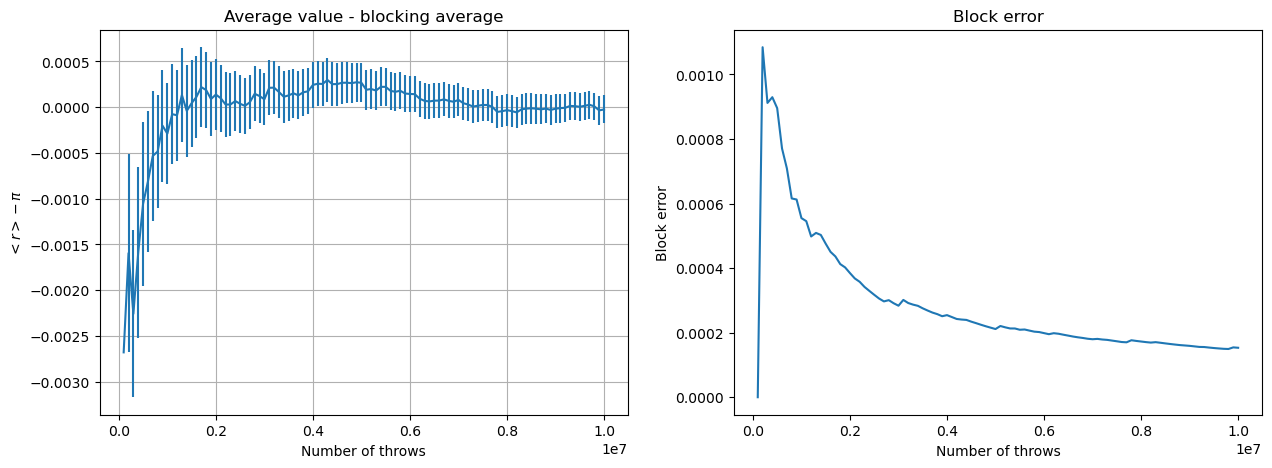

In [17]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex_02.1a.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-1, yerr=block_error)
plt.title("Average value - blocking average")
plt.xlabel('Number of throws')
plt.ylabel("$<r> - \pi$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error)
plt.title("Block error")
plt.xlabel('Number of throws')
plt.ylabel('Block error')

plt.show()


<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6029/2355994050.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$<r> - \pi$")


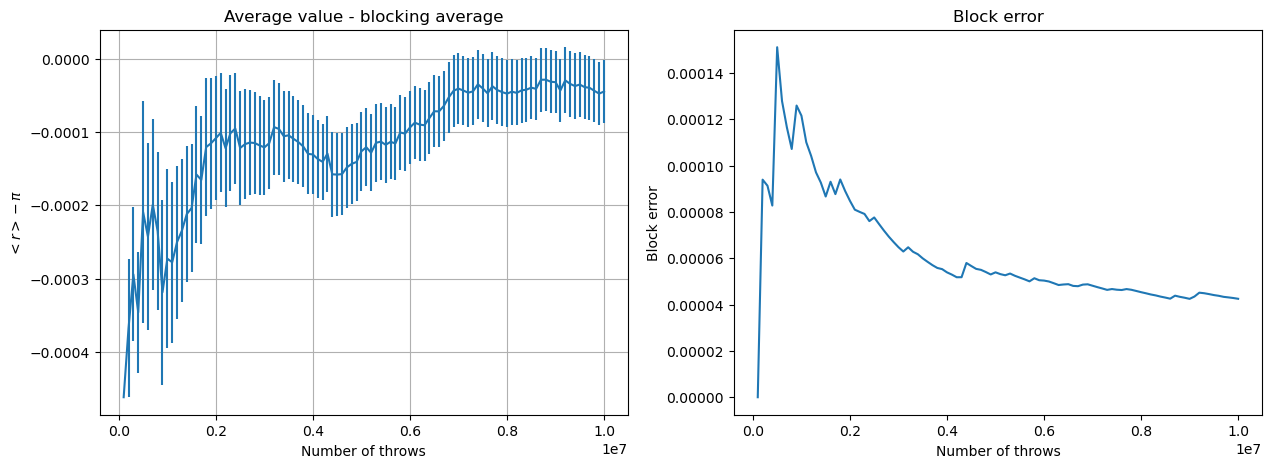

In [18]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex_02.1b.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-1, yerr=block_error)
plt.title("Average value - blocking average")
plt.xlabel('Number of throws')
plt.ylabel("$<r> - \pi$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error)
plt.title("Block error")
plt.xlabel('Number of throws')
plt.ylabel('Block error')

plt.show()


<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_6029/1469653604.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$<r> - \pi$")


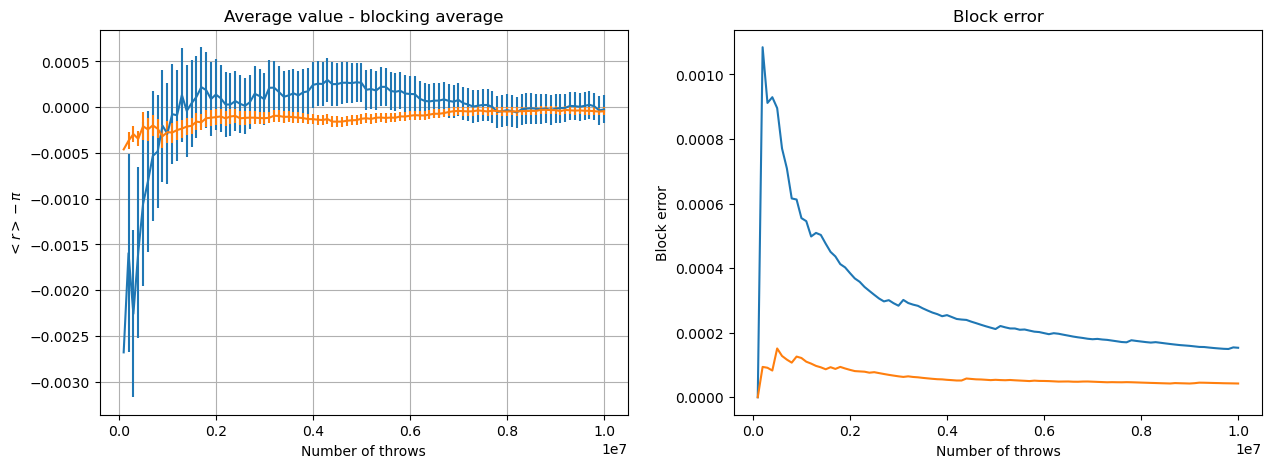

In [19]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex_02.1a.dat", unpack=True, usecols=(0,1,2))
vn_throws, vcum_avg, vblock_error = np.loadtxt("../data/ex_02.1b.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-1, yerr=block_error)
plt.errorbar(vn_throws, vcum_avg-1, yerr=vblock_error)
plt.title("Average value - blocking average")
plt.xlabel('Number of throws')
plt.ylabel("$<r> - \pi$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error)
plt.plot(vn_throws, vblock_error)
plt.title("Block error")
plt.xlabel('Number of throws')
plt.ylabel('Block error')

plt.show()

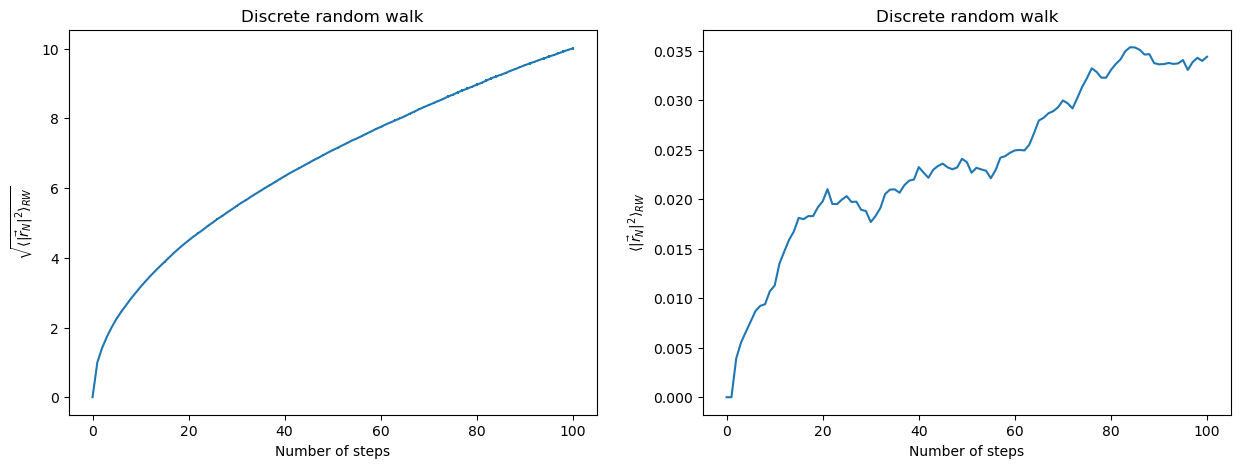

In [20]:
step, cum_avg, cumerror = np.loadtxt("../data/ex_02.2a.dat", unpack=True, usecols=(0,1, 2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(step, cum_avg, yerr=cumerror)
plt.title("Discrete random walk")
plt.xlabel("Number of steps")
plt.ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$')

plt.subplot(1,2,2)
plt.plot(step, cumerror)
plt.title("Discrete random walk")
plt.xlabel("Number of steps")
plt.ylabel(r'$\langle |\vec{r}_N|^2 \rangle_{RW}$')

plt.show()

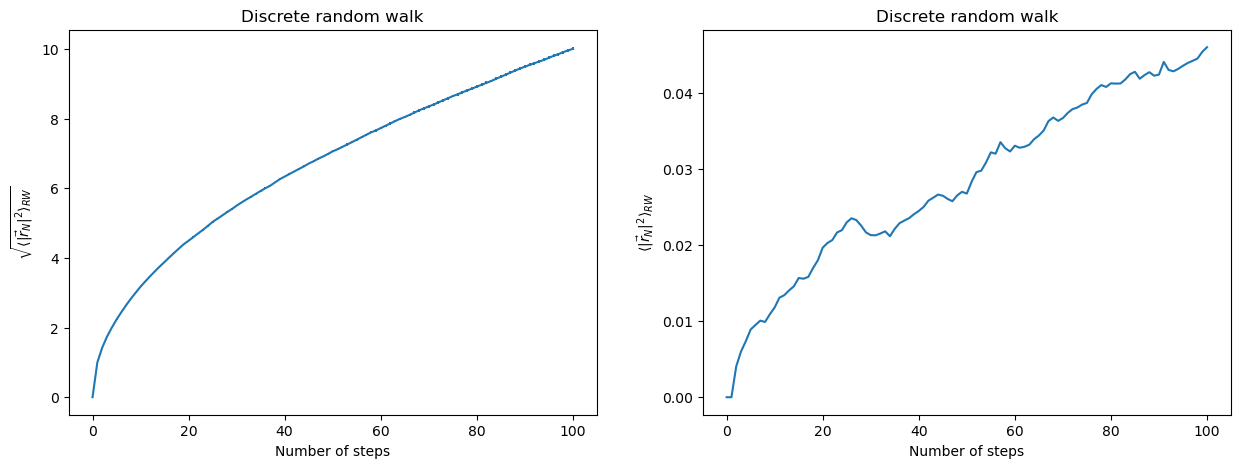

In [21]:
step, cum_avg, cumerror = np.loadtxt("../data/ex_02.2b.dat", unpack=True, usecols=(0,1, 2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(step, cum_avg, yerr=cumerror)
plt.title("Discrete random walk")
plt.xlabel("Number of steps")
plt.ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$')

plt.subplot(1,2,2)
plt.plot(step, cumerror)
plt.title("Discrete random walk")
plt.xlabel("Number of steps")
plt.ylabel(r'$\langle |\vec{r}_N|^2 \rangle_{RW}$')

plt.show()